# フィラデルフィア半導体株指数 週足 メディアン統計

In [1]:
import sys
path_up = '..'
if not path_up in sys.path:
    sys.path.append(path_up)

In [2]:
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import mplfinance as mpf
import numpy as np
import pandas as pd
import seaborn as sns
import yfinance as yf

from funcs.technical import calc_robust_bollinger

code = 'SOX'
symbol = '^%s' % code
#symbol = 'USDJPY=X'
ticker = yf.Ticker(symbol)
df = ticker.history(period='3y', interval='1wk')
df

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2022-03-21 00:00:00-04:00,3413.659912,3535.409912,3359.379883,3525.340088,0,0.0,0.0
2022-03-28 00:00:00-04:00,3501.790039,3633.139893,3317.879883,3366.639893,0,0.0,0.0
2022-04-04 00:00:00-04:00,3380.610107,3428.659912,3116.669922,3120.159912,0,0.0,0.0
2022-04-11 00:00:00-04:00,3067.979980,3145.750000,3026.770020,3028.219971,0,0.0,0.0
2022-04-18 00:00:00-04:00,3017.959961,3227.179932,2988.419922,2989.830078,0,0.0,0.0
...,...,...,...,...,...,...,...
2025-02-17 00:00:00-05:00,5209.979980,5366.319824,5120.029785,5136.589844,0,0.0,0.0
2025-02-24 00:00:00-05:00,5155.370117,5167.439941,4634.950195,4766.750000,0,0.0,0.0
2025-03-03 00:00:00-05:00,4817.669922,4827.569824,4455.759766,4629.589844,0,0.0,0.0


In [3]:
df0 = ticker.history(period='5y', interval='1wk')
df0

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2020-03-16 00:00:00-04:00,1375.010010,1408.989990,1296.439941,1298.540039,0,0.0,0.0
2020-03-23 00:00:00-04:00,1315.199951,1574.619995,1280.750000,1488.750000,0,0.0,0.0
2020-03-30 00:00:00-04:00,1506.459961,1568.050049,1414.260010,1443.040039,0,0.0,0.0
2020-04-06 00:00:00-04:00,1514.099976,1673.650024,1508.739990,1601.729980,0,0.0,0.0
2020-04-13 00:00:00-04:00,1591.260010,1724.760010,1585.699951,1705.640015,0,0.0,0.0
...,...,...,...,...,...,...,...
2025-02-17 00:00:00-05:00,5209.979980,5366.319824,5120.029785,5136.589844,0,0.0,0.0
2025-02-24 00:00:00-05:00,5155.370117,5167.439941,4634.950195,4766.750000,0,0.0,0.0
2025-03-03 00:00:00-05:00,4817.669922,4827.569824,4455.759766,4629.589844,0,0.0,0.0


## Moving Median

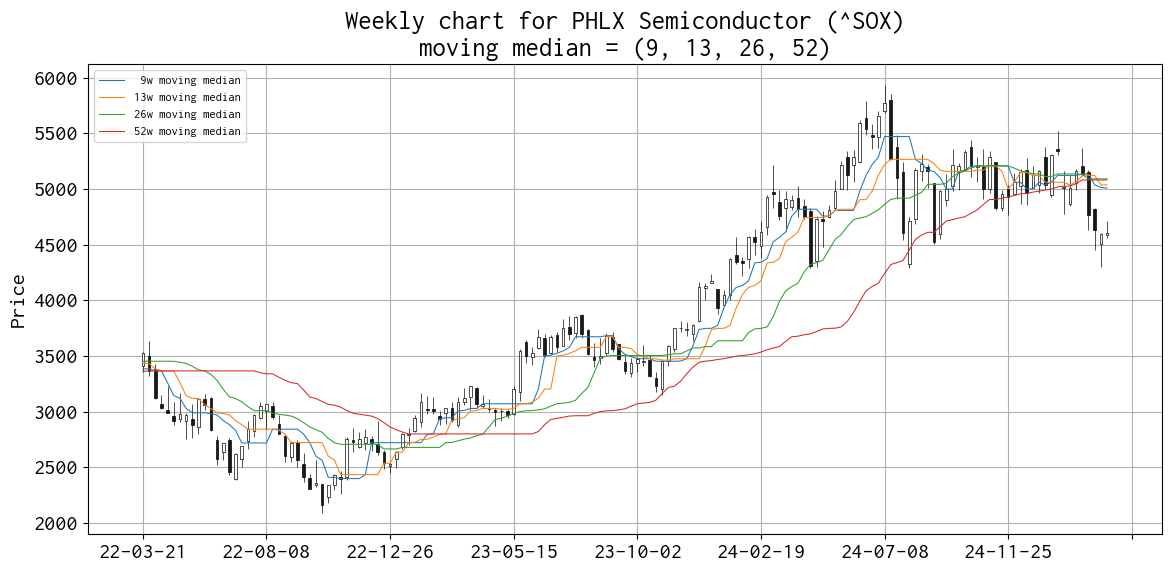

In [4]:
FONT_PATH = "../fonts/RictyDiminished-Regular.ttf"
fm.fontManager.addfont(FONT_PATH)

# FontPropertiesオブジェクト生成（名前の取得のため）
font_prop = fm.FontProperties(fname=FONT_PATH)
font_prop.get_name()

plt.rcParams['font.family'] = font_prop.get_name()
plt.rcParams['font.size'] = 16

fig, ax = plt.subplots(figsize=(12, 6))

mm09 = df0['Close'].rolling(9).median()
mm13 = df0['Close'].rolling(13).median()
mm26 = df0['Close'].rolling(26).median()
mm52 = df0['Close'].rolling(52).median()

apds  = [
    mpf.make_addplot(mm09[df.index], width=0.75, label=' 9w moving median', ax=ax),
    mpf.make_addplot(mm13[df.index], width=0.75, label='13w moving median', ax=ax),
    mpf.make_addplot(mm26[df.index], width=0.75, label='26w moving median', ax=ax),
    mpf.make_addplot(mm52[df.index], width=0.75, label='52w moving median', ax=ax),
]   

mpf.plot(
    df, type='candle', style='default',
    datetime_format='%y-%m-%d',
    addplot=apds,
    xrotation=0,
    ax=ax,
)
ax.set_title('Weekly chart for %s (%s)\nmoving median = (9, 13, 26, 52)' %(ticker.info['longName'], symbol))
ax.grid()
ax.legend(loc='upper left', fontsize=9)

plt.tight_layout()
plt.savefig('report_weekly_chart_median_%s.png' % code)
plt.show()

In [5]:
df.tail(2)

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2025-03-10 00:00:00-04:00,4508.640137,4608.689941,4300.490234,4598.790039,0,0.0,0.0
2025-03-17 00:00:00-04:00,4587.109863,4709.379883,4558.589844,4601.373047,0,0.0,0.0


In [6]:
df.tail(2)['Close']

Date
2025-03-10 00:00:00-04:00    4598.790039
2025-03-17 00:00:00-04:00    4601.373047
Name: Close, dtype: float64

In [7]:
df.tail(2)['Close'].diff()

Date
2025-03-10 00:00:00-04:00         NaN
2025-03-17 00:00:00-04:00    2.583008
Name: Close, dtype: float64

In [8]:
df['Close'].tail(1) - df['Open'].tail(1)

Date
2025-03-17 00:00:00-04:00    14.263184
dtype: float64

In [9]:
df['Close'].rolling(9).median().tail()

Date
2025-02-17 00:00:00-05:00    5136.589844
2025-02-24 00:00:00-05:00    5136.589844
2025-03-03 00:00:00-05:00    5037.470215
2025-03-10 00:00:00-04:00    5015.850098
2025-03-17 00:00:00-04:00    5009.339844
Name: Close, dtype: float64

In [10]:
df['Close'].rolling(13).median().tail()

Date
2025-02-17 00:00:00-05:00    5122.970215
2025-02-24 00:00:00-05:00    5122.970215
2025-03-03 00:00:00-05:00    5122.970215
2025-03-10 00:00:00-04:00    5037.470215
2025-03-17 00:00:00-04:00    5037.470215
Name: Close, dtype: float64

In [11]:
df['Close'].rolling(26).median().tail()

Date
2025-02-17 00:00:00-05:00    5129.780029
2025-02-24 00:00:00-05:00    5092.135010
2025-03-03 00:00:00-05:00    5092.135010
2025-03-10 00:00:00-04:00    5092.135010
2025-03-17 00:00:00-04:00    5092.135010
Name: Close, dtype: float64

In [12]:
df['Close'].rolling(52).median().tail()

Date
2025-02-17 00:00:00-05:00    5082.214844
2025-02-24 00:00:00-05:00    5082.214844
2025-03-03 00:00:00-05:00    5082.214844
2025-03-10 00:00:00-04:00    5082.214844
2025-03-17 00:00:00-04:00    5082.214844
Name: Close, dtype: float64

## Robust Bollinger bands

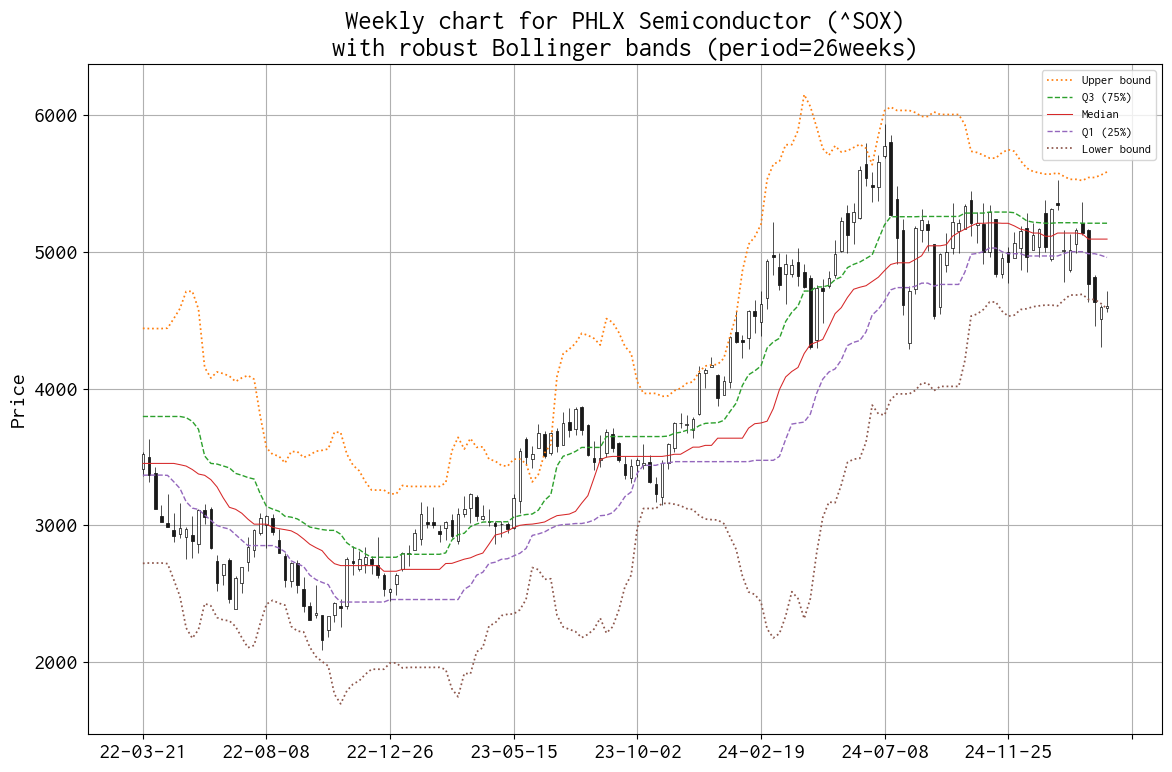

In [13]:
FONT_PATH = "../fonts/RictyDiminished-Regular.ttf"
fm.fontManager.addfont(FONT_PATH)

# FontPropertiesオブジェクト生成（名前の取得のため）
font_prop = fm.FontProperties(fname=FONT_PATH)
font_prop.get_name()

plt.rcParams['font.family'] = font_prop.get_name()
plt.rcParams['font.size'] = 16

fig, ax = plt.subplots(figsize=(12, 8))

# Bollinger bands
period = 26
mv_median = df0['Close'].rolling(period).median()
mv_q1 = df0['Close'].rolling(period).quantile(.25)
mv_q3 = df0['Close'].rolling(period).quantile(.75)
mv_iqr = mv_q3 - mv_q1
mv_lower = mv_q1 - mv_iqr * 1.5
mv_upper = mv_q3 + mv_iqr * 1.5

apds  = [
    mpf.make_addplot(mv_upper[df.index], width=1.25, color='C1', linestyle='dotted', label='Upper bound', ax=ax),
    mpf.make_addplot(mv_q3[df.index], width=1, color='C2', linestyle='dashed', label='Q3 (75%)', ax=ax),
    mpf.make_addplot(mv_median[df.index], width=0.75, color='C3', label='Median', ax=ax),
    mpf.make_addplot(mv_q1[df.index], width=1, color='C4', linestyle='dashed', label='Q1 (25%)', ax=ax),
    mpf.make_addplot(mv_lower[df.index], width=1.25, color='C5', linestyle='dotted', label='Lower bound', ax=ax),
]   

mpf.plot(
    df, type='candle', style='default',
    addplot=apds,
    datetime_format='%y-%m-%d',
    xrotation=0,
    ax=ax,
)

ax.grid()
ax.legend(loc='best', fontsize=9)

try:
    ax.set_title('Weekly chart for %s (%s)\nwith robust Bollinger bands (period=%dweeks)' % (ticker.info['longName'], symbol, period))
except KeyError:
    ax.set_title('Weekly chart for %s\nwith robust Bollinger bands (period=%sweeks)' % (symbol, period))

plt.tight_layout()
plt.savefig('report_weekly_chart_bollinger_robust_%s.png' % code)
plt.show()

## ヒストグラム

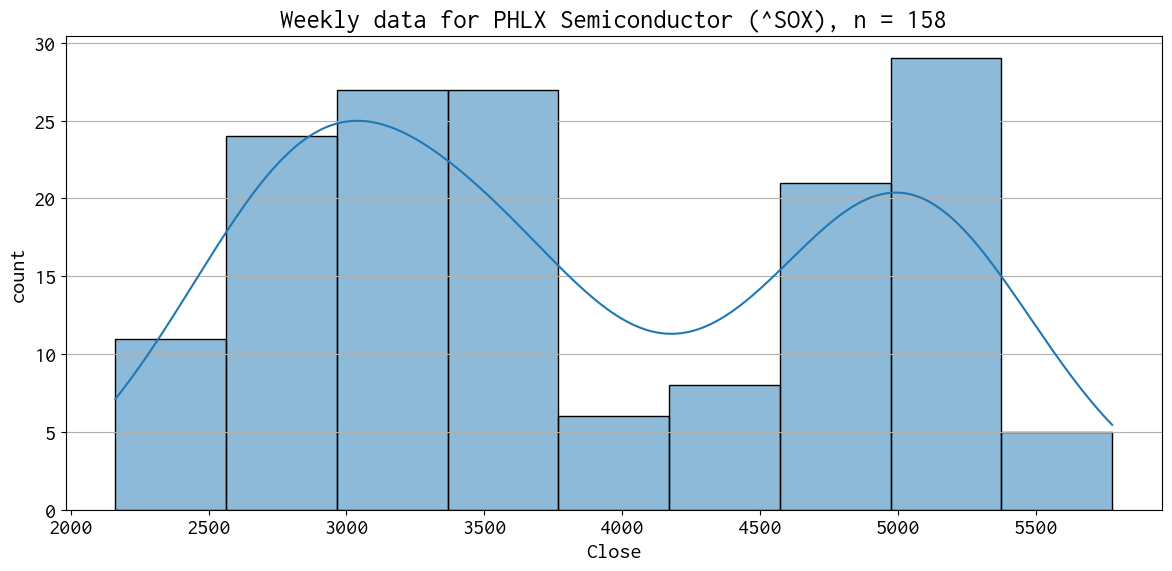

In [15]:
plt.rcParams['font.size'] = 16
fig = plt.figure(figsize=(12, 6))
#ax = fig.add_axes(111)
ax = fig.add_subplot(111)

sns.histplot(
    df['Close'],
    kde=True,
    ax=ax
)

ax.set_xlabel("Close")
ax.set_ylabel("count")
ax.set_title('Weekly data for %s (%s), n = %d' % (ticker.info['longName'], symbol, len(df)))
ax.grid(axis = 'y')

plt.tight_layout()
plt.savefig('report_weekly_histogram_%s.png' % code)
plt.show()